In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [ ]:
!ls /content/gdrive/'My Drive'/SMSSpamCollection

'/content/gdrive/My Drive/SMSSpamCollection'


Part 1A: 

In [ ]:
count = 0
for line in open('/content/gdrive/My Drive/SMSSpamCollection'):   #Spam message
  if line[0] == 's':
    print(line)
    break
for line in open('/content/gdrive/My Drive/SMSSpamCollection'):   #Legitimate message
  if line[0] == 'h':
    print(line)
    break

spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's

ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...



Part 1B

In [ ]:
for line in open('/content/gdrive/My Drive/SMSSpamCollection'):   #747 spam messages
  if line[0] == 's':
    count += 1
print(count)

for line in open('/content/gdrive/My Drive/SMSSpamCollection'):   #5574 spam messages
  if line[0] == 'h':
    count += 1
print(count)

747
5574


Part 1C

Advantage: 

1. By using character level RNN, the model is able to learn specific words like names, places.

2. character level RNN does less encoding, less memory required, since there are 26 letters in English and some puntuation marks, where as word- level need to encode thousands of words.

Disadvantage:

1. Computationally expensive because char-based RNN will have more tokens than a word-based RNN model, given the same sentence

2. The character level RNN learns the word rather than learning the context.

Part 1D

In [ ]:
import torchtext
text_field = torchtext.data.Field(sequential=True,      # text sequence
                                  tokenize=lambda x: x, # because are building a character-RNN
                                  include_lengths=True, # to track the length of sequences, for batching
                                  batch_first=True,
                                  use_vocab=True)       # to turn each character into an integer index
label_field = torchtext.data.Field(sequential=False,    # not a sequence
                                   use_vocab=False,     # don't need to track vocabulary
                                   is_target=True,      
                                   batch_first=True,
                                   preprocessing=lambda x: int(x == 'spam')) # convert text to 0 and 1

fields = [('label', label_field), ('sms', text_field)]
dataset = torchtext.data.TabularDataset("/content/gdrive/My Drive/SMSSpamCollection", # name of the file
                                        "tsv",               # fields are separated by a tab
                                        fields)
# dataset[0].sms
# dataset[0].label

train, valid, test= dataset.split(split_ratio = [0.6,0.2,0.2],
                                  stratified = True, strata_field = 'label')

print(len(train))
print(len(valid))
len(test)

3343
1115


1114

Part 1E

Having a balanced training set is helpful for training our neural network because it will prevent the model from overfitting to the training set. For now the dataset contains a large portion of the label "ham", if 9 out of 10 samples have the "ham" label, then the model will not be able to learn what really differs from "spam" and "ham". To think from a extreme perspective, if the entire dataset only has 'ham' label, the model would not be able to compute the loss after a few iterations because it overfits to the dataset. If an unseen spam message is fed into the model, it is highly likely that the model will still predict it as a normal message.

In [ ]:
# save the original training examples
old_train_examples = train.examples
# get all the spam messages in `train`
train_spam = []
for item in train.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train.examples = old_train_examples + train_spam * 6

Part 1F

In [ ]:
text_field.build_vocab(train)
#text_field.vocab.stoi                     # a dictionary that displays the assigned integer from its string
#text_field.vocab.itos                      # a dictionary that displays the string based on the integer index

Part 1G

UNK is used to replace the rare words that did not fit in your vocabulary. This will not be used in Character-level RNN


PAD is used to pad the data so that each batch of sequence has the same length. 

In [ ]:
text_field.vocab.stoi  

defaultdict(<function torchtext.vocab._default_unk_index>,
            {'\t': 106,
             '\n': 107,
             ' ': 2,
             '!': 45,
             '"': 78,
             '#': 80,
             '$': 86,
             '%': 91,
             '&': 63,
             "'": 59,
             '(': 79,
             ')': 73,
             '*': 71,
             '+': 75,
             ',': 46,
             '-': 64,
             '.': 16,
             '/': 60,
             '0': 13,
             '1': 23,
             '2': 26,
             '3': 42,
             '4': 37,
             '5': 32,
             '6': 41,
             '7': 40,
             '8': 28,
             '9': 47,
             ':': 65,
             ';': 74,
             '<': 87,
             '<pad>': 1,
             '<unk>': 0,
             '=': 84,
             '>': 81,
             '?': 61,
             '@': 82,
             'A': 39,
             'B': 56,
             'C': 34,
             'D': 54,
             'E': 30,
        

Part 1H

In [ ]:
train_iter = torchtext.data.BucketIterator(train,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

for i, batch in enumerate(train_iter):
  if i >= 10:
    break
  print("Batch number {0} has {1} maximum input".format(i+1,batch.sms[1][0].item()))
  count = 0
  for j in range(32):
    if batch.label[j].item() == 1:
      count += 1
  print("Batch number {0} has {1} paddings".format(i+1,count))


Batch number 1 has 157 maximum input
Batch number 1 has 29 paddings
Batch number 2 has 137 maximum input
Batch number 2 has 28 paddings
Batch number 3 has 96 maximum input
Batch number 3 has 15 paddings
Batch number 4 has 120 maximum input
Batch number 4 has 22 paddings
Batch number 5 has 144 maximum input
Batch number 5 has 30 paddings
Batch number 6 has 77 maximum input
Batch number 6 has 3 paddings
Batch number 7 has 28 maximum input
Batch number 7 has 0 paddings
Batch number 8 has 169 maximum input
Batch number 8 has 20 paddings
Batch number 9 has 159 maximum input
Batch number 9 has 30 paddings
Batch number 10 has 83 maximum input
Batch number 10 has 17 paddings


Part 2

In [ ]:

import torch.nn as nn
import torch
import numpy
# You mind find this code helpful for obtaining
# pytorch one-hot vectors.

ident = torch.eye(10, dtype = torch.float32)
#ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])


In [ ]:
len(text_field.vocab.stoi)

120

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(RNN, self).__init__()
        self.ident = torch.eye(128, dtype = torch.float32)
        #self.emb = nn.Embedding(len(text_field.vocab.stoi), hidden_size)
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(128, num_classes)
    
    def forward(self, x):
        # Look up the embedding
        x = self.ident[x]
        # Set an initial hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        # Forward propagate the RNN
        out, _ = self.rnn(x)
        # Pass the output of the last time step to the classifier
        out = torch.cat([torch.max(out, dim=1)[0], 
                 torch.mean(out, dim=1)], dim=1)
        out = self.fc(out)
        return out




Part 3A

In [ ]:
def get_accuracy(model, data):
    """ 
    Compute the accuracy of the `model` across a dataset `data`
    
    Example usage:
    
    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid) # the variable `valid` is from above
    """
    iterate = torchtext.data.BucketIterator(data,batch_size=32,sort_key=lambda x:len(x.sms),repeat=False)
    correct, total = 0, 0
    for i, batch in enumerate(iterate):
        output = model(batch.sms[0])
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(batch.label.view_as(pred)).sum().item()
        total += batch.sms[1].shape[0]
    return correct / total

Part 3B

In [ ]:
import matplotlib.pyplot as plt
def train_rnn_network(model, train, valid, num_epochs=30, learning_rate=1e-5, batch_size=32):
    iterate = torchtext.data.BucketIterator(train,batch_size=batch_size,sort_key=lambda x: len(x.sms),sort_within_batch=True,repeat=False)              
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses, train_acc, valid_acc = [], [], []
    loss = 0
    epochs = []
    for epoch in range(num_epochs):
      for b in iterate:
          label = b.label
          sms = b.sms
          optimizer.zero_grad()
          pred = model(sms[0])
          loss = criterion(pred, label)
          loss.backward()
          optimizer.step()
      losses.append(float(loss))

      epochs.append(epoch)
      train_acc.append(get_accuracy(model, train))
      valid_acc.append(get_accuracy(model, valid))
      print("Epoch %d; Loss %f; Train Acc %f; Val Acc %f" % (epoch+1, loss, train_acc[-1], valid_acc[-1]))
    # plotting
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()


Epoch 1; Loss 0.671835; Train Acc 0.519980; Val Acc 0.134529
Epoch 2; Loss 0.726535; Train Acc 0.519980; Val Acc 0.134529
Epoch 3; Loss 0.672060; Train Acc 0.519980; Val Acc 0.134529
Epoch 4; Loss 0.666719; Train Acc 0.519980; Val Acc 0.134529
Epoch 5; Loss 0.703987; Train Acc 0.519980; Val Acc 0.134529
Epoch 6; Loss 0.668261; Train Acc 0.519980; Val Acc 0.134529
Epoch 7; Loss 0.659904; Train Acc 0.519980; Val Acc 0.134529
Epoch 8; Loss 0.650932; Train Acc 0.519980; Val Acc 0.134529
Epoch 9; Loss 0.731287; Train Acc 0.519980; Val Acc 0.134529
Epoch 10; Loss 0.731209; Train Acc 0.519980; Val Acc 0.134529
Epoch 11; Loss 0.729569; Train Acc 0.519980; Val Acc 0.134529
Epoch 12; Loss 0.727047; Train Acc 0.519980; Val Acc 0.134529
Epoch 13; Loss 0.688497; Train Acc 0.519980; Val Acc 0.134529
Epoch 14; Loss 0.648580; Train Acc 0.519980; Val Acc 0.134529
Epoch 15; Loss 0.643007; Train Acc 0.521307; Val Acc 0.138117
Epoch 16; Loss 0.674247; Train Acc 0.533908; Val Acc 0.156951
Epoch 17; Loss 0.

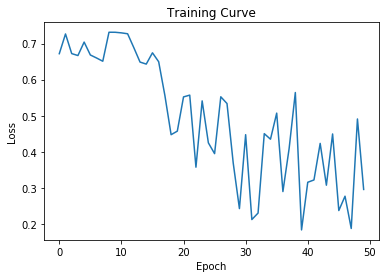

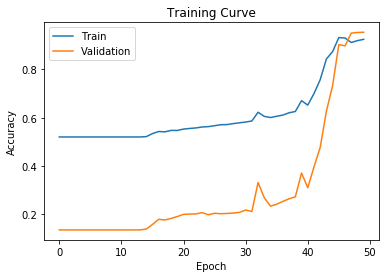

In [ ]:
the_model = RNN(128,64,2)
train_rnn_network(the_model, train, valid, num_epochs=50,
                  learning_rate=1e-5)

Part 3C

4 hyper parameters I chose to tune:

1. Learning rate: Initially used 1e-5. The result looked good with high training and validation accuracy. I decided to increase and decrease the learning rate to see if it helps improving the results. Increasing the learning rate did not increase the final accuracy (tried 5e-5 and 1e-4. 1e-4 resulted a little bit more noisy training curve.) Decreasing the learning rate the 1e-6. The training accuracy increased very slowly per epoch, so I decided to use 1e-5.

2. Batch size: tried 32,64,128,256. Wanted to see if increasing the batch size would improve the results while saving computational time. Turned out that 64 did not cause the model to improve accuracy, and 128 and 256 caused the model to have lower peak accuracy.

3. Epoch. Tried 5,30, 50, 70.  Tried 5 just to make sure the model is working. Increased to 30 but the accuracy seemed to still have room to increase. Increased to 50 and training accuracy appeared to stop increasing at epoch 44. Increased to 70 to see if the accuracy would change or increase, but it did not. 

4. input_size and output_size of the model. Tried 128, 256. 128 have almost the same training/validation accuracy. 256 had no improvements.

Overall, my best model is trained based on the following hyperparameters:

Lr = 1e-5, Batch size = 32, epoch = 50, input size and output size = 128

Part 3D

In [ ]:
# Create a Dataset of only spam validation examples
valid_spam = torchtext.data.Dataset(
    [e for e in valid.examples if e.label == 1],
    valid.fields)
# Create a Dataset of only non-spam validation examples
valid_nospam = torchtext.data.Dataset(
    [e for e in valid.examples if e.label == 0],
    valid.fields)

print(1-get_accuracy(the_model,valid_spam))  #error rate on predicting based on dataset consists of only spam messages
print(1-get_accuracy(the_model,valid_nospam))  #error rate on predicting based on dataset consists of only non-spam messages

0.17333333333333334
0.02694300518134718


Part 3E:

If the user gets a spam email, the algorithm would most likely flag it (~80% accuracy) as spam message, which is good. Even if it got it wrong, the user can judge the email by himself and delete the email.

If the user gets a real email, the algorithm would likely to leave it in the inbox (~97% accuracy) as a normal message, which is good. If it flagged it wrong(6.21%), the user would be impacted because it is then moved to junk emails and would not be seen by the user.

Therefore, It is important that the algorithm has a very low false positive rate.

Part 4A

In [ ]:
print(get_accuracy(the_model,test)) #94.7%

0.9470377019748654


Part 4B

In [ ]:
# Create a Dataset of only spam test examples
test_spam = torchtext.data.Dataset(
    [e for e in test.examples if e.label == 1],
    test.fields)
# Create a Dataset of only non-spam test examples
test_nospam = torchtext.data.Dataset(
    [e for e in test.examples if e.label == 0],
    test.fields)

print(1-get_accuracy(the_model,test_spam))  #error rate on predicting based on dataset consists of only spam messages
print(1-get_accuracy(the_model,test_nospam))  #error rate on predicting based on dataset consists of only non-spam messages

0.17449664429530198
0.033160621761658016


Part 4C

In [ ]:
import torch.nn.functional as F
msg = "machine learning is sooo cool!"               
x = []
for i in msg:
  a = text_field.vocab.stoi[i]
  x.append(a)
x = torch.tensor(x)
x = x.resize(1,30)
output = the_model(x)
prob = F.softmax(output, dim=1)
print(prob)         #19.04% 

tensor([[0.8096, 0.1904]], grad_fn=<SoftmaxBackward>)


/usr/local/lib/python3.6/dist-packages/torch/tensor.py:339: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Part 4D


I think that it is not hard to detect if a message is a spam or not, if we use word-level based RNN model, because most spam messages contains the same group of words such as "free", "prize", "won",etc...

To build a baseline model, what can be done is to simply build an algorithm that flags messages that contains common words ( examples above) in a typical spam message as spam, and compute accuracy using the test dataset. There is a good chance the message is indeed spam message. If the network accuracy is lower than this, than it means there is a problem. Because the model is expected to learn these common words during training.